<a href="https://colab.research.google.com/github/artvanila/data_projects/blob/main/T_Mobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aircrash Analysis

## Introduction

Let's analyze the aircrash dataset and find out the following:


*   Identification of the most dangerous operator.
*   Identification of the most often crash cause.  
*   Is the most often crash cause the most dangerous one as well? If not which one is the most dangerous?
*   Which variable (day / night, season of the year …)  is the most important for prediction crash cause?
*   Find any interesting trends/behaviors that you encounter when you analyze the dataset.

Before starting the research, we will import the necessary libraries and create functions to be used in the project.

In [1]:
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive

In [94]:
from scipy.stats import chi2_contingency

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Adjust the path according to the dataset location, otherwise, the notebook will not work.
file_path = '/content/drive/MyDrive/Researches/TM/Airplane_Crashes_Since_1908.csv'

In [7]:
def primary_analysis(df):

    print("Information about the dataframe:")
    print(df.info())

    print("\nFirst 5 rows of the dataframe:")
    print(df.head())

    print("\nDescription of numerical columns:")
    print(df.describe())

    print("\nNumber of duplicate entries in the dataset:")
    print(df.duplicated().sum())

    print("\nNumber of missing values in the dataset:")
    print(df.isna().sum())

    print("\nFrequency distributions for categorical columns:")

    for column in df.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumn '{column}':")
        print(df[column].value_counts())

In [8]:
def data_loss(df, df_raw, column_name='name'):
    # Absolute loss
    loss_absolute = df_raw[column_name].count() - df[column_name].count()

    # Relative loss percentage
    loss_relative = 100 - (df[column_name].count() / df_raw[column_name].count() * 100)
    loss_relative = round(loss_relative, 2)

    # Convert to string and add '%' symbol
    loss_relative = str(loss_relative) + '%'

    print(f'Absolute data loss in column {column_name}: {loss_absolute}')
    print(f'Relative data loss in column {column_name}: {loss_relative}')

In [9]:
df = pd.read_csv(file_path)

In [10]:
df_raw = pd.read_csv(file_path)

In [11]:
primary_analysis(df)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3561 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
dtypes: float64(3), object(10)
memory usage: 535.2+ KB
None

First 5 rows of the dataframe:
         Date   Time                            Location  \
0  09/17/1908  17:18                 Fort Myer, Virginia   
1  

Let's start with column descriptions:

*   `Date` – the recorded date of the incident.
*   `Time` – the exact or approximate time of the incident (if known).
*   `Location` – the city, country, or coordinates where the crash occurred.
*   `Operator` – the airline or organization operating the aircraft.
*   `Flight` – the flight identification number (if applicable).
*   `Route` – the flight path (e.g., Moscow – Saint Petersburg) or the purpose of the flight (e.g., training, sightseeing, test flight).
*   `Type` – the type/model of aircraft involved.
*   `Registration` – the unique aircraft registration number (e.g., I-TAVI).
*   `Cn/In` – the aircraft’s factory-assigned construction number (Construction Number).
*   `Aboard` – the total number of passengers and crew members.
*   `Fatalities` – the number of deaths among those on the aircraft.
*   `Ground` – the number of casualties among people not on the aircraft (e.g., if the plane crashed into a building or road).
*   `Summary` – a brief description of the incident.

Based on the initial data analysis, several key preprocessing steps have been identified (each of these aspects will be examined in detail in the next chapter):

1.   Column names standardization – renaming columns to a Python-friendly format for consistency and ease of use.
2.   Data types correction – identifying columns that require type conversion (e.g., Date and Time should be in datetime format, not object).
3.   Missing values correction – detecting missing values in columns and determining the appropriate approach to fill or remove them.
4.   Duplicate detection – while no obvious duplicates are present, it is necessary to check for hidden duplicates by analyzing unique values across key columns
5.   Analyzing quantitative data – checking Board, Fatalities, Ground for outliers and setting appropriate threshold values.
6.   Feature Engineering – ensuring that the cleaned dataset is ready for answering research questions and creating new variables from existing data
7. Summary Column Correction - summary column contains detailed descriptions of accident causes, this data will help if we use a machine learning model to accurately identify and classify the true cause of the accident without details.

## Data Preprocessing

Let's go through each point in detail.

### Column Names Standardization

Let's clean up the column styles—remove unnecessary values, issues, and standardize everything to lowercase.

In [12]:
df.rename(columns={
    'Date': 'date',
    'Time': 'time',
    'Location': 'location',
    'Operator': 'operator',
    'Flight #': 'flight_number',
    'Route': 'route',
    'Type': 'aircraft_type',
    'Registration': 'registration',
    'cn/In': 'serial_number',
    'Aboard': 'aboard',
    'Fatalities': 'aboard_fatalities',
    'Ground': 'ground_fatalities',
    'Summary': 'summary'
}, inplace=True)

In [13]:
df_raw.rename(columns={
    'Date': 'date',
    'Time': 'time',
    'Location': 'location',
    'Operator': 'operator',
    'Flight #': 'flight_number',
    'Route': 'route',
    'Type': 'aircraft_type',
    'Registration': 'registration',
    'cn/In': 'serial_number',
    'Aboard': 'aboard',
    'Fatalities': 'aboard_fatalities',
    'Ground': 'ground_fatalities',
    'Summary': 'summary'
}, inplace=True)

### Data Types Correction

Now, let's work on data types:

*   Date: Convert to datetime
*   Time: Convert to datetime.time
*   Aboard, Fatalities, Ground: Convert to int

In [14]:
df['date'] = pd.to_datetime(df['date'])

In [15]:
df['time'] = df['time'].astype(str).str.strip()
df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.time

<ipython-input-15-5e8befea2f2a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.time


In [16]:
num_cols = ['aboard', 'aboard_fatalities', 'ground_fatalities']
df = df.dropna(subset=num_cols)
df[num_cols] = df[num_cols].astype(int)

<ipython-input-16-23f522da321a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = df[num_cols].astype(int)


In [17]:
df.drop(df[df['aboard'] == 0].index, inplace=True) # let's also delete rows with zero people aboard

<ipython-input-17-d8e3844de4d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['aboard'] == 0].index, inplace=True) # let's also delete rows with zero people aboard


### Missing Values Correction

Now, let's work with missing values.

*   `date` has 0 missing values so let's move on.
*   The `time` column contains 2219 missing values, which may be due to the absence of recorded times in the original data. Since filling in the missing values with arbitrary data could distort the analysis, it was decided to leave the NaT values as they are. This approach ensures the integrity of the analysis and avoids making incorrect assumptions.
*   The `location` column has only 20 missing values, and filling them with "Unknown" would be the worst solution.
*   The `operator` column has only 18 missing values, and filling them with "Unknown" would be the best solution.
*   The `flight_number` column has 4199 missing values. We will not use it in the data analysis, as the data is missing for a significant portion and restoring it would be unreasonable. However, we will not delete the column, as it won't interfere with the analysis. Instead, we will again fill the missing values with "Unknown".
*   For all the following textual columns ( with `route` 1707 missing values, `aircraft_type` with 27, `registration` with 335, `serial_number` with 1228, and `summary` with 390), we will apply the same approach — replace all missing values with "Unknown".
*   The missing values in `aboard`, `aboard_fatalities`, and `ground_fatalities` were handled in the previous section, so we will leave everything as it is.

In [18]:
text_columns = ['operator','location', 'flight_number', 'route', 'aircraft_type', 'registration', 'serial_number', 'summary']
df[text_columns] = df[text_columns].fillna('Unknown')

In [19]:
print(df.isna().sum())

date                    0
time                 2201
location                0
operator                0
flight_number           0
route                   0
aircraft_type           0
registration            0
serial_number           0
aboard                  0
aboard_fatalities       0
ground_fatalities       0
summary                 0
dtype: int64


In [20]:
data_loss(df, df_raw, column_name='date')

Absolute data loss in column date: 34
Relative data loss in column date: 0.65%


The data loss is less than 1%, so we can move on.

### Duplicate Detection

Let's check the top-20 most frequent unique values in all columns.

In [21]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"\nColumn '{column}':")
    print(df[column].value_counts().head(20))


Column 'time':
time
15:00:00    32
12:00:00    30
11:00:00    29
16:00:00    26
19:30:00    26
14:00:00    25
19:00:00    24
09:30:00    23
10:30:00    22
17:00:00    22
13:00:00    20
17:30:00    19
08:30:00    19
14:30:00    19
20:30:00    19
08:00:00    18
20:00:00    17
10:15:00    17
16:30:00    17
12:30:00    17
Name: count, dtype: int64

Column 'location':
location
Unknown                   19
Moscow, Russia            15
Sao Paulo, Brazil         15
Rio de Janeiro, Brazil    14
Anchorage, Alaska         13
Manila, Philippines       13
Bogota, Colombia          13
New York, New York        12
Cairo, Egypt              12
Chicago, Illinois         11
Tehran, Iran               9
AtlantiOcean               9
Near Moscow, Russia        9
Rome, Italy                8
Amsterdam, Netherlands     8
Denver, Colorado           8
Ankara, Turkey             8
Paris, France              8
Bucharest, Romania         7
London, England            7
Name: count, dtype: int64

Column 'operator'

In this step, the following modifications will be made to ensure consistency and improve data quality:


*   flight_number column: Replaced all occurrences of "-" with "Unknown" to indicate missing data.
*   route column: Replaced the value "Test" with "Test flight" to make the description more precise.
*   summary column: Applied a category_mapping dictionary to consolidate similar categories. For example:
  *   Different variations of crashes during takeoff were grouped under one category:"Crashed during takeoff (or shortly after)".
  *   Various types of collisions (e.g., with the sea or mountains) were merged into a single category: "Crashed into an obstacle (mountain, sea, etc.)".

These changes were made to reduce the number of unique values in the dataset and simplify subsequent analysis.

In [22]:
df['flight_number'] = df['flight_number'].replace('-', 'Unknown')
df['route'] = df['route'].replace('Test', 'Test flight')

In [23]:
category_mapping = {
    'Crashed during takeoff.': 'Crashed during takeoff (or shortly after)',
    'Crashed while en route.': 'Crashed en route',
    'Crashed into the sea.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Crashed into a mountain.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Crashed into the ocean.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Struck a mountain.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Crashed on takeoff.': 'Crashed during takeoff (or shortly after)',
    'Crashed on take off.': 'Crashed during takeoff (or shortly after)',
    'Crashed shortly after taking off.': 'Crashed during takeoff (or shortly after)',
    'Crashed en route.': 'Crashed en route',
    'Crashed into a mountain while en route.': 'Crashed en route',
    'Flew into a mountain.': 'Crashed into an obstacle (mountain, sea, etc.)',
    'Cargo plane.': 'Cargo plane crash',
    'Pilot error.': 'Pilot error',
    'Engine failure.': 'Engine failure',
    'Crashed on approach.': 'Crashed during approach',
    'Weather related.': 'Weather related',
    'Crashed while attempting to land.': 'Crashed while attempting to land',
    'Crashed while landing.': 'Crashed while attempting to land',
    'The cargo plane crashed.': 'Cargo plane crash',
    'Crashed during approach.': 'Crashed during approach',
    'Disappeared while en route.': 'Disappeared while en route',
    'Crashed in poor weather conditions.': 'Weather related',
    'Crashed in fog.': 'Weather related',
    'Crashed during a landing attempt.': 'Crashed while attempting to land',
    'Crashed shortly after takeoff.': 'Crashed during takeoff (or shortly after)',
    'Crashed into mountains.': 'Crashed into an obstacle (mountain, sea, etc.)',
}

df['summary'] = df['summary'].replace(category_mapping)

In [24]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"\nColumn '{column}':")
    print(df[column].value_counts().head(20))


Column 'time':
time
15:00:00    32
12:00:00    30
11:00:00    29
16:00:00    26
19:30:00    26
14:00:00    25
19:00:00    24
09:30:00    23
10:30:00    22
17:00:00    22
13:00:00    20
17:30:00    19
08:30:00    19
14:30:00    19
20:30:00    19
08:00:00    18
20:00:00    17
10:15:00    17
16:30:00    17
12:30:00    17
Name: count, dtype: int64

Column 'location':
location
Unknown                   19
Moscow, Russia            15
Sao Paulo, Brazil         15
Rio de Janeiro, Brazil    14
Anchorage, Alaska         13
Manila, Philippines       13
Bogota, Colombia          13
New York, New York        12
Cairo, Egypt              12
Chicago, Illinois         11
Tehran, Iran               9
AtlantiOcean               9
Near Moscow, Russia        9
Rome, Italy                8
Amsterdam, Netherlands     8
Denver, Colorado           8
Ankara, Turkey             8
Paris, France              8
Bucharest, Romania         7
London, England            7
Name: count, dtype: int64

Column 'operator'

### Analyzing Quantitative Data

Let's create a bpx plot and analyze quantitative data - aboard aboard_fatalities, ground_fatalities.

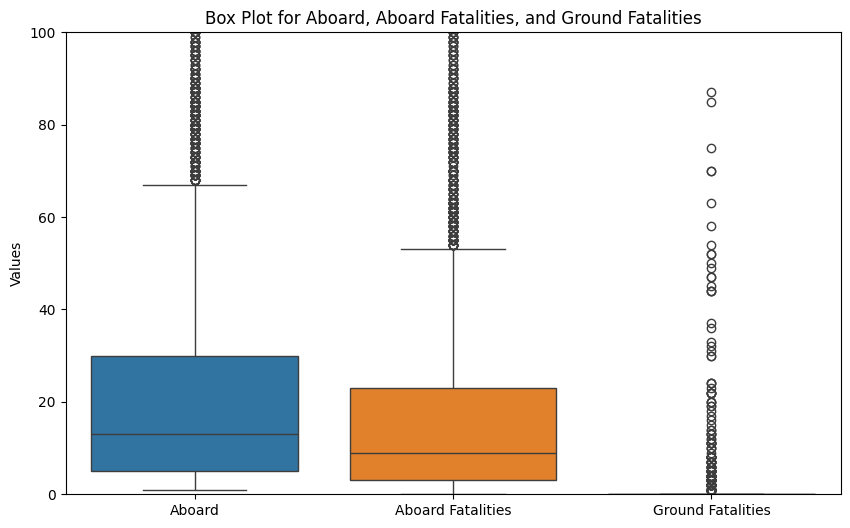

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['aboard', 'aboard_fatalities', 'ground_fatalities']])
plt.title('Box Plot for Aboard, Aboard Fatalities, and Ground Fatalities')
plt.ylim(0, 100) # there are outliers with large values, so we will limit the graph along the y-axis.
plt.ylabel('Values')
plt.xticks([0, 1, 2], ['Aboard', 'Aboard Fatalities', 'Ground Fatalities'])
plt.show()

In [26]:
print("\nDescription of numerical columns:")
print(df[['aboard', 'aboard_fatalities', 'ground_fatalities']].describe())


Description of numerical columns:
            aboard  aboard_fatalities  ground_fatalities
count  5234.000000        5234.000000        5234.000000
mean     27.599733          20.112533           1.597440
std      43.114499          33.242367          54.045063
min       1.000000           0.000000           0.000000
25%       5.000000           3.000000           0.000000
50%      13.000000           9.000000           0.000000
75%      30.000000          23.000000           0.000000
max     644.000000         583.000000        2750.000000


**Aboard**

*   Mean: 27.60 people on board.
*   Standard Deviation (Std): 43.11, indicating high variability.
*   Minimum (Min): 1 person (likely involving small private planes).
*   Maximum (Max): 644 people, likely related to large airliners.
*   Median (50%): 13 people, which is lower than the mean, indicating right-skewed asymmetry (rare but large disasters).
*   In 25% of cases, there were 5 or fewer people on board.
*   In 75% of cases, there were no more than 30 people on board.

Smaller planes are more common than large airliners.

**Aboard Fatalities**

*   Mean: 20.11 fatalities on board.
*   Standard Deviation (Std): 33.24, indicating high dispersion
*   Minimum (Min): 0 (there are accidents where no one died aboard, that doesn't mean that no one died on the ground).
*   Maximum (Max): 583 fatalities
*   Median (50%): 9 fatalities, which is less than the mean, meaning there are rare accidents with a high number of fatalities.
*   In 25% of cases, 3 or fewer people died.
*   In 75% of cases, 23 or fewer people died.

Most accidents still had a relatively small number of fatalities.

**Ground Fatalities**

*   Mean: 1.60 fatalities on the ground.
*   Standard Deviation (Std): 54.04, a very high value, indicating rare but extremely tragic incidents.
*   Minimum (Min): 0 (in most cases, there were no fatalities on the ground).
*   Maximum (Max): 2750 fatalities (referring to the September 11, 2001 terrorist attack)
*   Median (50%): 0 fatalities, meaning that in half of the cases, disasters did not affect people on the ground.
*   In 75% of cases, there were no fatalities on the ground.

However, the upper quartile (max outliers) shows rare disasters with large numbers of fatalities.

**Conclusion**


*   The data is highly asymmetric, especially for fatalities on board and on the ground (there are rare but extremely tragic incidents).
*   In most disasters, no one died on the ground, but some incidents resulted in a huge number of fatalities.
*   The number of passengers and fatalities on board has a wide range, which is due to the differences between private and commercial planes. Therefore, it is useful to explore the quantitative data separately for each sector: military, private, and commercial
*   The mean values are higher than the median, indicating the impact of rare disasters with mass fatalities.
*   We will remove the largest outlier — the September 11th attack on the Twin Towers, as this event can be considered extraordinary and does not fit into the overall statistics.

In [27]:
min_val_gf = df['ground_fatalities'].min()
q1_gf = df['ground_fatalities'].quantile(0.25)
median_gf = df['ground_fatalities'].mean()
q3_gf = df['ground_fatalities'].quantile(0.75)
max_val_gf = df['ground_fatalities'].max()

In [28]:
iqr_gf = q3_gf - q1_gf
lower_gf = q1_gf - 1.5 * iqr_gf
upper_gf = q3_gf + 1.5 * iqr_gf

In [29]:
display(f"Minimum value (min): {min_val_gf}")
display(f"25th percentile (Q1): {q1_gf}")
display(f"Median (50%): {median_gf}")
display(f"75th percentile (Q3): {q3_gf}")
display(f"Maximum value (max): {max_val_gf}")
display(f"IQR: {iqr_gf}")
display(f"Lower bound for outliers: {lower_gf}")
display(f"Upper bound for outliers: {upper_gf}")

'Minimum value (min): 0'

'25th percentile (Q1): 0.0'

'Median (50%): 1.5974398165838746'

'75th percentile (Q3): 0.0'

'Maximum value (max): 2750'

'IQR: 0.0'

'Lower bound for outliers: 0.0'

'Upper bound for outliers: 0.0'

In [30]:
df = df[~df['ground_fatalities'].isin([2750])]

In [31]:
print(df[['ground_fatalities']].describe())

       ground_fatalities
count        5232.000000
mean            0.546827
std             5.729160
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max           225.000000


### Feature Engineering

Add new features for further data analysis:


*   Let's add new variable `Fatality Rate `(Fatalities / Aboard category). This parameter will help us determine the degree of danger — the one that leads to the highest number of deaths per person on board. If the Fatality Rate ≈ 1, it means almost everyone on board has died.
*   Extract `Year` and `Month` from the `Date` column.
*   Create categories for the `time of day`: Morning, Afternoon, Evening, and Night.
*   Add a parameter to indicate whether there were `fatalities on the ground `(Yes/No).
*   And lastly, let's create a `flight category` that shows whether the flight is military, private, or commercial.

In [32]:
df['fatality_rate'] = df['aboard_fatalities'] / df['aboard']

<ipython-input-32-27eee0ea6aa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fatality_rate'] = df['aboard_fatalities'] / df['aboard']


In [33]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [34]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

In [35]:
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
def categorize_time_of_day(hour):
    if 6 <= hour < 18:
        return 'Day'
    else:
        return 'Night'

df['time_of_day'] = df['time'].apply(lambda x: categorize_time_of_day(x.hour))

In [36]:
df['bool_fg'] = df['ground_fatalities'].apply(lambda x: True if x > 0 else False)

In [37]:
def categorize_flight(row):
    if 'military' in str(row['operator']).lower():
        return 'military'
    elif row['aboard'] <= 20:
        return 'private & services'
    else:
        return 'commercial'

df['flight_category'] = df.apply(categorize_flight, axis=1)

In [38]:
def extract_country(location: str) -> str:
    parts = location.split(", ")

    if len(parts) == 1:
        return location
    elif len(parts) == 2:
        return parts[1]
    else:
        return ", ".join(parts[2:])

def process_dataframe(df: pd.DataFrame, column_name: str, new_column_name: str) -> pd.DataFrame:
    df[new_column_name] = df[column_name].apply(extract_country)
    return df

df = process_dataframe(df, "location", "generalized_crash_location")

In [39]:
def split_route(df, route_column):
    df['departure_location'] = df[route_column].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) and ' - ' in x else 'Unknown')
    df['arrival_location'] = df[route_column].apply(lambda x: x.split(' - ')[1] if isinstance(x, str) and ' - ' in x else 'Unknown')
    df.loc[~df[route_column].str.contains(' - '), ['departure_location', 'arrival_location']] = 'Unknown'
    return df

df = split_route(df, 'route')

In [40]:
df

,date,time,location,operator,flight_number,route,aircraft_type,registration,serial_number,aboard,...,fatality_rate,year,month,season,time_of_day,bool_fg,flight_category,generalized_crash_location,departure_location,arrival_location
0,1908-09-17,17:18:00,"Fort Myer, Virginia",Military - U.S. Army,Unknown,Demonstration,Wright Flyer III,Unknown,1,2,...,0.500,1908,9,Fall,Day,False,military,Virginia,Unknown,Unknown
1,1912-07-12,06:30:00,"AtlantiCity, New Jersey",Military - U.S. Navy,Unknown,Test flight,Dirigible,Unknown,Unknown,5,...,1.000,1912,7,Summer,Day,False,military,New Jersey,Unknown,Unknown
2,1913-08-06,NaT,"Victoria, British Columbia, Canada",Private,Unknown,Unknown,Curtiss seaplane,Unknown,Unknown,1,...,1.000,1913,8,Summer,Night,False,private & services,Canada,Unknown,Unknown
3,1913-09-09,18:30:00,Over the North Sea,Military - German Navy,Unknown,Unknown,Zeppelin L-1 (airship),Unknown,Unknown,20,...,0.700,1913,9,Fall,Night,False,military,Over the North Sea,Unknown,Unknown
4,1913-10-17,10:30:00,"Near Johannisthal, Germany",Military - German Navy,Unknown,Unknown,Zeppelin L-2 (airship),Unknown,Unknown,30,...,1.000,1913,10,Fall,Day,False,military,Germany,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5262,2009-05-03,12:00:00,"Near El Alto de Rubio, Venezuela",Military - Venezuelan Army,Unknown,Patrol,Mi-35,EV08114,Unknown,18,...,1.000,2009,5,Spring,Day,False,military,Venezuela,Unknown,Unknown
5263,2009-05-20,06:30:00,"Near Madiun, Indonesia",Military - Indonesian Air Force,Unknown,Jakarta - Maduin,Lockheed C-130 Hercules,A-1325,1982,112,...,0.875,2009,5,Spring,Day,True,military,Indonesia,Jakarta,Maduin
5265,2009-06-01,00:15:00,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,447,Rio de Janeiro - Paris,Airbus A330-203,F-GZCP,660,228,...,1.000,2009,6,Summer,Night,False,commercial,Brazil,Rio de Janeiro,Paris
5266,2009-06-07,08:30:00,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,Unknown,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,C-FJJR,424,1,...,1.000,2009,6,Summer,Day,False,private & services,Canada,Lourdes de BlanSablon,Port Hope Simpson


### Summary Column Correction

The Summary column contains a large amount of information in text form, which provides detailed descriptions of the causes and circumstances of the accidents. For a more accurate analysis, it is recommended to extract the main causes from these descriptions and classify them among the most common incident causes, which we have identified as follows:

*   Crashed into an obstacle (mountain, sea, etc.)
*   Crashed during takeoff (or shortly after)
*   Crashed en route
*   Cargo plane crash
*   Weather related
*   Crashed while attempting to land
*   Crashed during approach
*   Pilot error
*   Engine failure
*   Shot down by enemy forces

Because I did not initially assess the time required for analyzing this dataset, I was unable to complete this task. However, if I am given a bit more time, I will be able to finish the analysis and refine the results.

In the meantime, I would like to describe how I would proceed. In my opinion, this is a supervised learning task within the framework of classification.

First, I would prepare the text for analysis by performing the following steps:


*   Tokenization: Breaking the text into individual words or phrases.
*   Stopword removal: Eliminating commonly occurring words such as "and," "in," "on," which do not carry significant meaning.
*   Lemmatization: Reducing words to their base form
*   Removal of punctuation and numbers

Converting the text into numerical representation, for example, using TfidfVectorizer:

In [98]:
#vectorizer = TfidfVectorizer(stop_words='english')
#X = vectorizer.fit_transform(texts)

Next, I would split the data into training and testing sets:

In [99]:
#X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

For classification, I would use the LogisticRegression method:

In [ ]:
#model = LogisticRegression()
#model.fit(X_train, y_train)

After that, I would evaluate the classification results:

In [ ]:
#y_pred = model.predict(X_test)
#print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

## EDA

Now the data is ready, and we can proceed with the research process by answering the following questions.

Let's identify the most dangerous operator in 3 different categroies - military, private, commercial

In [41]:
military_df = df[df['flight_category'] == 'military']
private_df = df[df['flight_category'] == 'private & services']
commercial_df = df[df['flight_category'] == 'commercial']

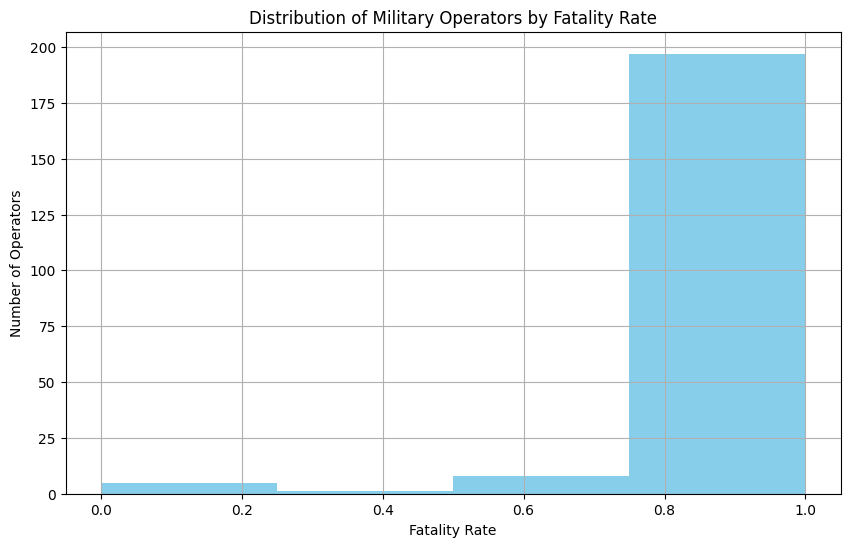

In [42]:
military_fatality_rate = military_df.groupby('operator')['fatality_rate'].mean().sort_values(ascending=False)
military_fatality_rate.plot(kind='hist', bins=4, color='skyblue', figsize=(10, 6))
plt.title('Distribution of Military Operators by Fatality Rate')
plt.xlabel('Fatality Rate')
plt.ylabel('Number of Operators')
plt.grid(True)
plt.show()

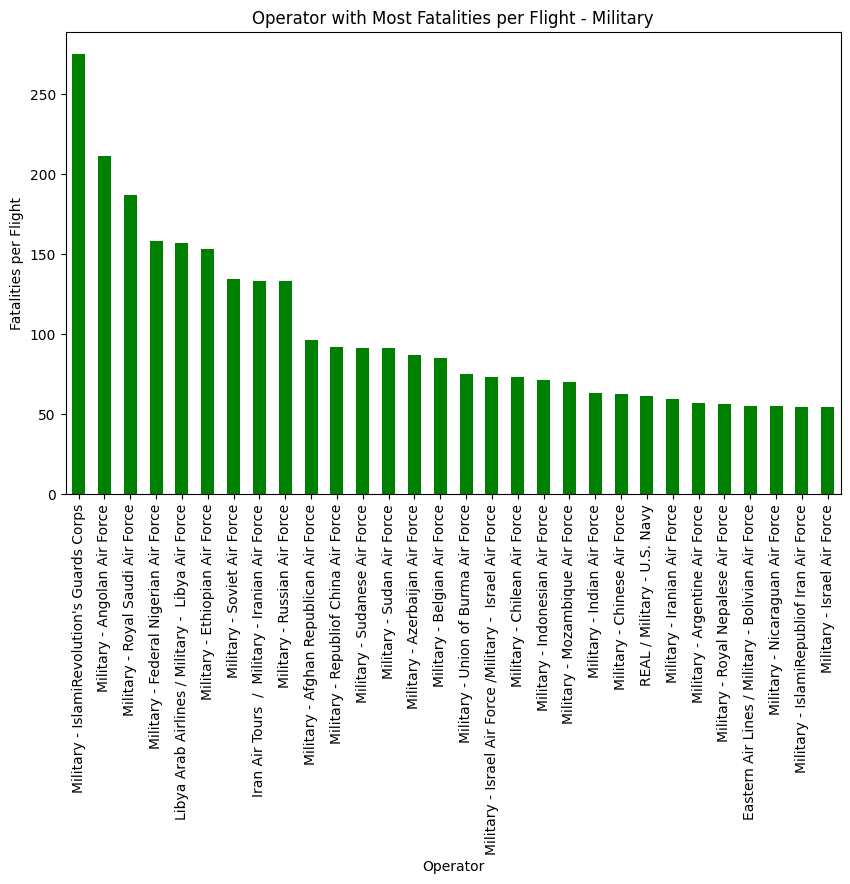

In [101]:
operator_group = military_df.groupby('operator')
flights_per_operator = operator_group['time'].count()
fatalities_per_operator = operator_group['aboard_fatalities'].sum()
fatalities_per_flight = fatalities_per_operator / flights_per_operator
fatalities_per_flight.replace([float('inf'), -float('inf')], 0, inplace=True)
fatalities_per_flight.fillna(0, inplace=True)
fatalities_per_flight.sort_values(ascending=False)
military_most_fatalities = fatalities_per_flight.sort_values(ascending=False).head(30)
military_most_fatalities.plot(kind='bar', figsize=(10, 6), color='green')
plt.title('Operator with Most Fatalities per Flight - Military')
plt.xlabel('Operator')
plt.ylabel('Fatalities per Flight')
plt.show()

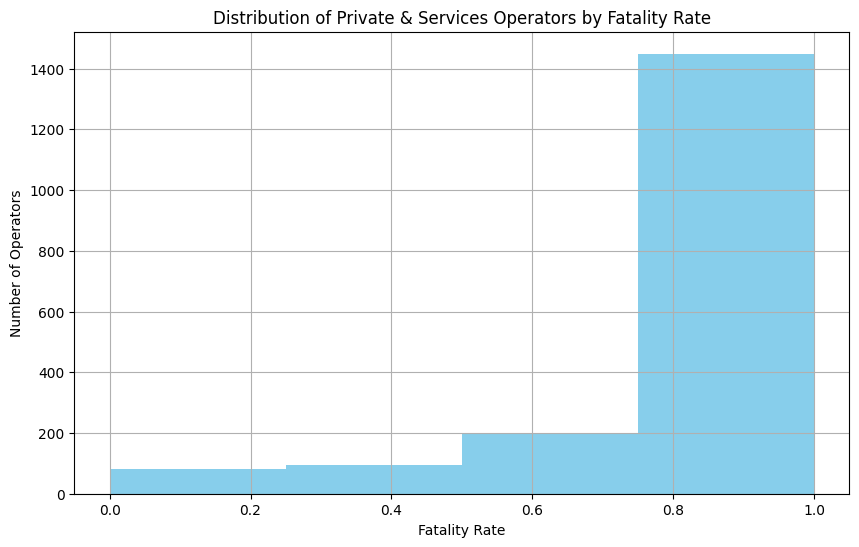

In [44]:
private_fatality_rate = private_df.groupby('operator')['fatality_rate'].mean().sort_values(ascending=False)
private_fatality_rate.plot(kind='hist', bins=4, color='skyblue', figsize=(10, 6))
plt.title('Distribution of Private & Services Operators by Fatality Rate')
plt.xlabel('Fatality Rate')
plt.ylabel('Number of Operators')
plt.grid(True)
plt.show()

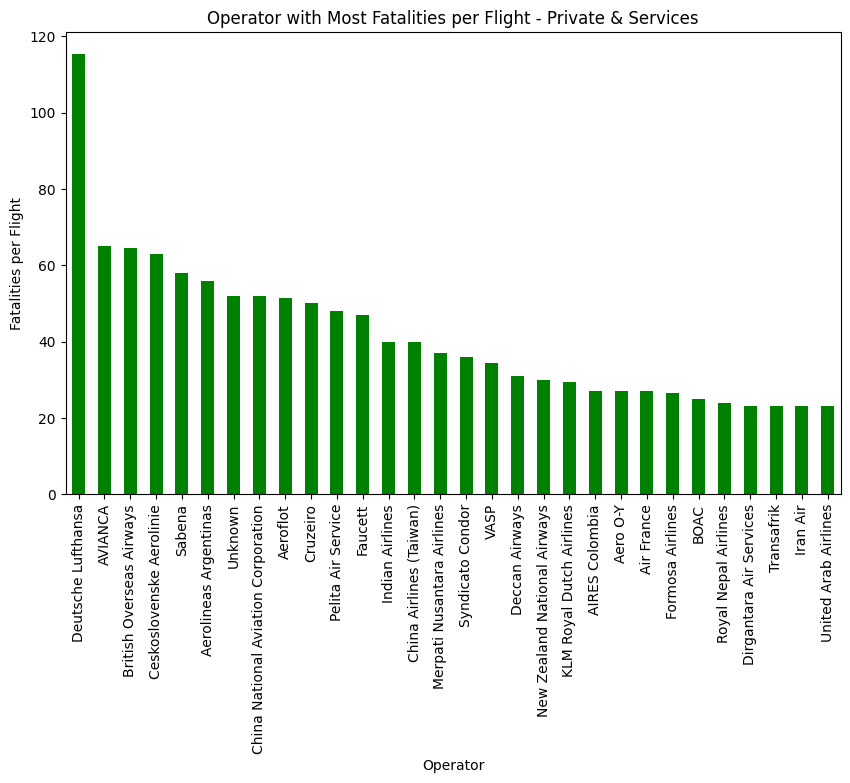

In [45]:
operator_group = private_df.groupby('operator')
flights_per_operator = operator_group['time'].count()
fatalities_per_operator = operator_group['aboard_fatalities'].sum()
fatalities_per_flight = fatalities_per_operator / flights_per_operator
fatalities_per_flight.replace([float('inf'), -float('inf')], 0, inplace=True)
fatalities_per_flight.fillna(0, inplace=True)
fatalities_per_flight.sort_values(ascending=False)
military_most_fatalities = fatalities_per_flight.sort_values(ascending=False).head(30)
military_most_fatalities.plot(kind='bar', figsize=(10, 6), color='green')
plt.title('Operator with Most Fatalities per Flight - Private & Services')
plt.xlabel('Operator')
plt.ylabel('Fatalities per Flight')
plt.show()

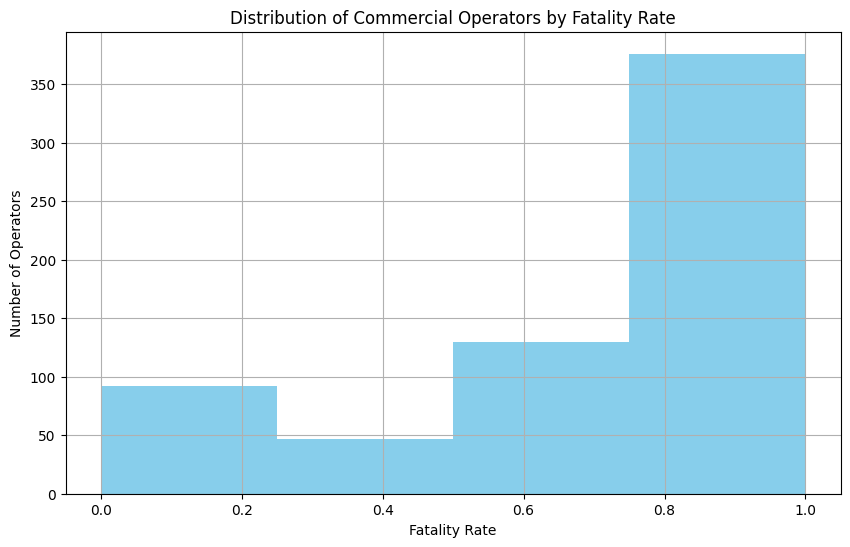

In [46]:
commercial_fatality_rate = commercial_df.groupby('operator')['fatality_rate'].mean().sort_values(ascending=False)
commercial_fatality_rate.plot(kind='hist', bins=4, color='skyblue', figsize=(10, 6))
plt.title('Distribution of Commercial Operators by Fatality Rate')
plt.xlabel('Fatality Rate')
plt.ylabel('Number of Operators')
plt.grid(True)
plt.show()

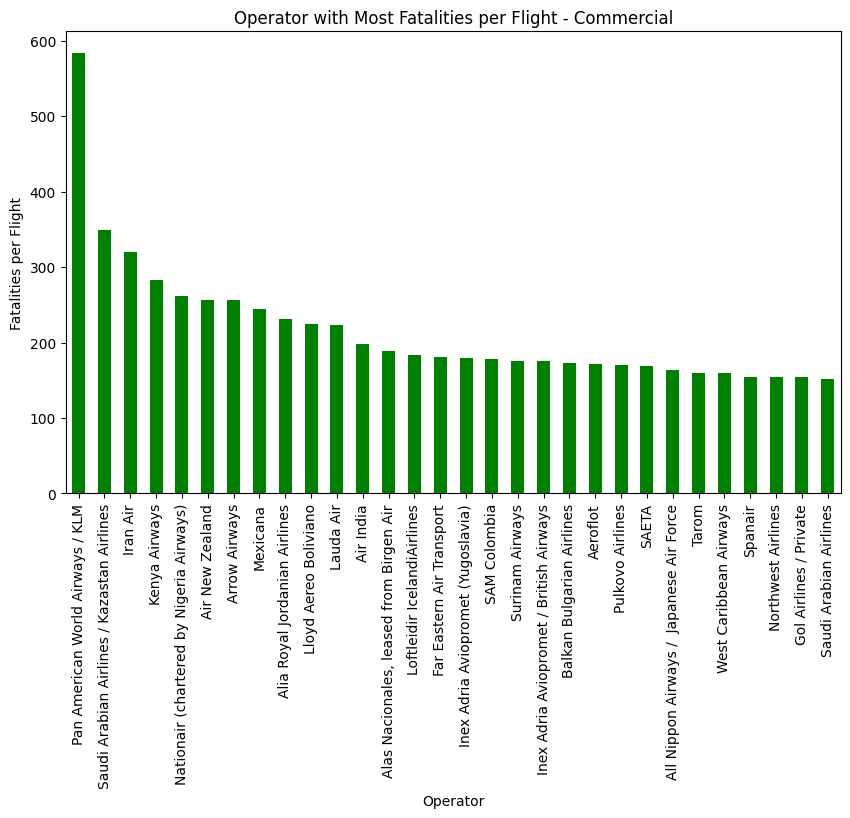

In [47]:
operator_group = commercial_df.groupby('operator')
flights_per_operator = operator_group['time'].count()
fatalities_per_operator = operator_group['aboard_fatalities'].sum()
fatalities_per_flight = fatalities_per_operator / flights_per_operator
fatalities_per_flight.replace([float('inf'), -float('inf')], 0, inplace=True)
fatalities_per_flight.fillna(0, inplace=True)
fatalities_per_flight.sort_values(ascending=False)
military_most_fatalities = fatalities_per_flight.sort_values(ascending=False).head(30)
military_most_fatalities.plot(kind='bar', figsize=(10, 6), color='green')
plt.title('Operator with Most Fatalities per Flight - Commercial')
plt.xlabel('Operator')
plt.ylabel('Fatalities per Flight')
plt.show()

Before we draw conclusions from these graphs, it is worth mentioning that:

- If an operator has few crashes but a high Fatality Rate, it could be a coincidence.
- If an operator has many crashes but a low Fatality Rate, it means that the accidents were not always fatal.

When analyzing the danger levels across different sectors of aviation, the commercial sector stands out as the least dangerous. This is supported by the fact that almost half of the operators in this segment have a fatality rate of less than 1. This indicates that fatal incidents occur less frequently in the commercial aviation sector, reflecting high safety standards and strict regulations followed by commercial airlines. In contrast, the military and private sectors show much more alarming statistics: nearly all accidents from operators in these sectors end in tragedies where the entire crew perishes. This can be attributed to the fact that military operators often carry out more risky missions in complex and hazardous conditions, as well as potential resource limitations for maintaining safety standards.

To assess the danger posed by operators more objectively, it makes sense to introduce a new parameter that calculates the number of fatalities per flight. This approach takes into account not only the number of deaths but also the activity level of operators. Logically, the more flights an operator conducts, the higher the probability of incidents. Therefore, the ratio of fatalities to flights provides a more accurate picture of the level of danger.

If we look at the military sector, the top operators with the highest fatalities per flight are as follows:

- Islamic Revolutionary Guards Corps
- Angolan Air Force
- Royal Saudi Air Force
- Federal Nigerian Air Force
- Libyan Arab Airlines
- Ethiopian Air Force
- Soviet Air Force
- Iranian Air Force
- Russian Air Force

Now, if we examine the private sector, the list of operators with the most fatalities per flight looks like this:

- Deutsche Lufthansa
- Avianca
- British Overseas Airways
- Czechoslovak Airlines
- Sabena
- Aerolíneas Argentinas
- China National Aviation Corporation
- Aeroflor
- Cruzeiro
- Pelita Air Service
- Faucett

In the commercial sector, the top operators are as follows:

- Pan American World Airways
- Saudi Arabian Airlines
- Iran Air
- Kenya Airways
- National Airlines
- Air New Zealand
- Arrow Air
- Mexicana
- Alia Royal Jordanian Airlines
- Lloyd Aero Boliviano
- LudaAir
- Air India

Let's identify the most common crash causes in different sectors and answer the question: Is the most frequent crash cause also the most dangerous one? If not, which one is the most dangerous?

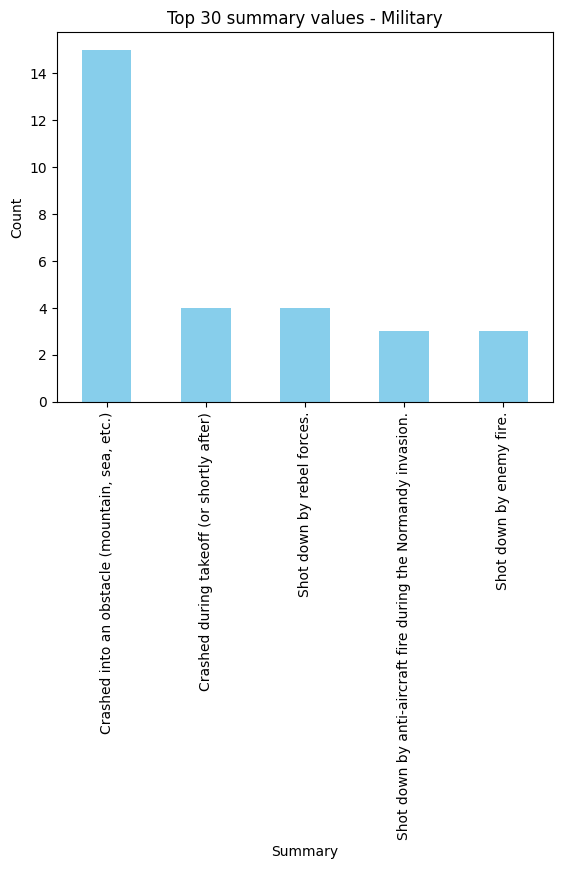

In [104]:
filtered_df = military_df[military_df['summary'] != 'Unknown']
top_causes = filtered_df['summary'].value_counts().head(5)
top_causes.plot(kind='bar', color='skyblue')
plt.title('Top 30 summary values - Military')
plt.xlabel('Summary')
plt.ylabel('Count')
plt.show()

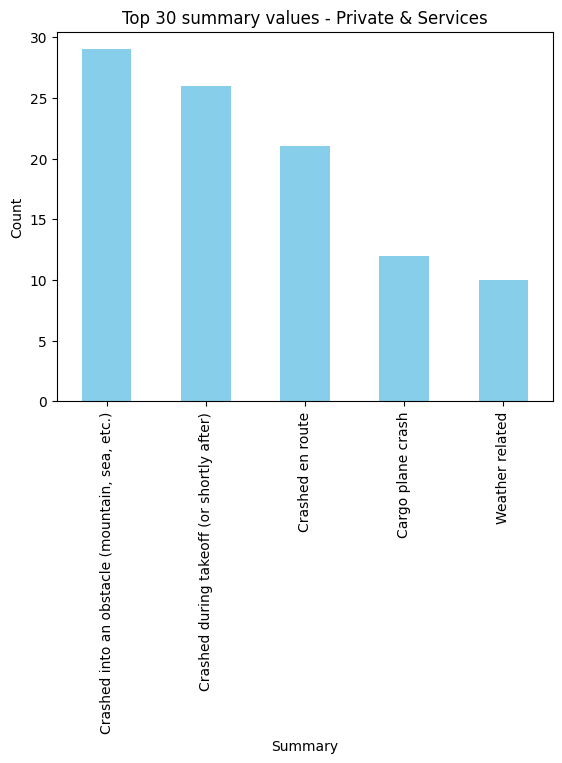

In [49]:
filtered_df = private_df[private_df['summary'] != 'Unknown']
top_causes = filtered_df['summary'].value_counts().head(5)
top_causes.plot(kind='bar', color='skyblue')
plt.title('Top 30 summary values - Private & Services')
plt.xlabel('Summary')
plt.ylabel('Count')
plt.show()

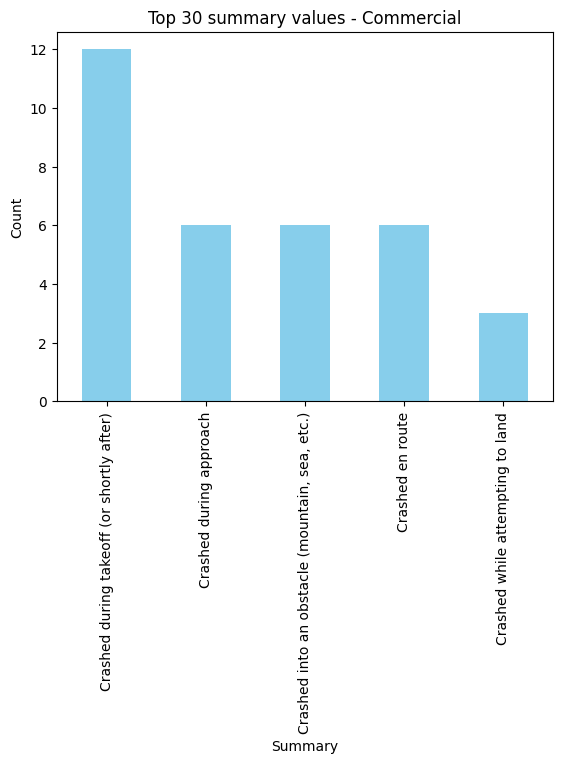

In [50]:
filtered_df = commercial_df[commercial_df['summary'] != 'Unknown']
top_causes = filtered_df['summary'].value_counts().head(5)
top_causes.plot(kind='bar', color='skyblue')
plt.title('Top 30 summary values - Commercial')
plt.xlabel('Summary')
plt.ylabel('Count')
plt.show()

Most common for military sector:

- Crashed into an obstacle
- Crashed during takeoff
- Shot down by rebel or enemy forces

Most common for private sector:

- Crashed into an obstacle
- Crashed during takeoff
- Crashed en route or weather-related

Most common for commercial sector:

- Crashed during takeoff
- Crashed during approach
- Crashed into an obstacle

In the military sector, crashes due to external threats, such as being shot down by rebel or enemy forces, are unique, highlighting the dangerous environments in which military aircraft operate. On the other hand, the private sector focuses on more operational issues, such as crashes due to obstacles or weather-related events during en-route flight, suggesting a higher vulnerability during less controlled circumstances.

The commercial sector, however, appears to be most affected by issues during takeoff and approach phases, which points to the critical nature of these stages in commercial aviation. Crashes during these phases may be attributed to factors such as technical failure, human error, or environmental conditions.

In all sectors, crashes caused by obstacles during takeoff and flight phases seem to be common, indicating the ongoing importance of ground safety measures, thorough pre-flight checks, and proper training in handling unexpected challenges during flight. Addressing weather-related issues and improving air traffic management can also contribute significantly to reducing risks, particularly in private and commercial aviation sectors.

To answer the question: Is the most frequent crash cause also the most dangerous one? If not, which one is the most dangerous? Let's again use the Fatal Rate parameter.

In [51]:
military_causes_fatality_rate = military_df.groupby('summary')['fatality_rate'].mean().sort_values(ascending=False).head(10)
military_causes_fatality_rate

,fatality_rate
summary,
Midair collision over the Gulf of Mexico while flying in formation. Eleven killed on each plane.,1.0
Struck a mountain,1.0
Shot down by enemy fire.,1.0
Shot down by friendly fire during the Gulf War. Thirteen killed on each helicopter.,1.0
Shot down by rebel forces.,1.0
Shot down by rebels near the Namibia border as it took off.,1.0
Shot down in flames by the British 39th Home Defence Squadron.,1.0
Shot down with a missile by Armenian forces while en route.,1.0
Shot down with a missile fired by UNITA rebels.,1.0


In [52]:
private_causes_fatality_rate = private_df.groupby('summary')['fatality_rate'].mean().sort_values(ascending=False).head(10)
private_causes_fatality_rate

,fatality_rate
summary,
"31-7952246The pilot reported that he had a rough running engine and was making an emergency landing at Charlo Airport. While maneuvering to land, he crashed 3 miles west of the runway. Loss of power from the right engine, and the pilot did not conserve altitude or configure the aircraft for maximum performance following the loss of power. Control of the aircraft was probably lost as the pilot was attempting to intercept the ILS for Runway 13 during a low-level turn. Contributing factors were the overweight condition of the aircraft and the lack of in-flight emergency procedures training received by the pilot.",1.0
The aircraft ran out of fuel and crashed into the sea. The last message that was heard from the crew was they were low on fuel and preparing to ditch.,1.0
The aircraft suffered an airframe failure while en route. Fatigue fracture of wing attachment fitting bolts. FAA replacement time exceeded.,1.0
The aircraft struck the northwestern slope of Stukel Mountain just after takeoff. Loss of control due to ice accretion on airframe surfaces. The pilot should have required that de-icing fluid be applied prior to takeoff.,1.0
"The aircraft struck the ground nose-first in a vertical attitude while en route and was completely demolished by the impact. Inability of the aircraft to gain or maintain altitude due to carburetor ice, propeller ice or wing ice or some combination of these icing conditions, while over terrain and in weather unsuitable for an emergency landing.",1.0
The aircraft struck high ground while attempting to land at Alice Springs after descending below mimimum descent altitude.,1.0
The aircraft struck a mountain. Continued VFR flight into adverse weather conditions.,1.0
The aircraft struck a mountain seven minutes before it was scheduled to land in the remote Indonesian province of Papua.,1.0
"The aircraft struck a mountain during an ILS approach to Tri-City Airport. Pilot's failure to identify an intersection properly, resulting in flying 15 miles beyond the outer marker and descending to an alititude too low to clear high terrain. An inoperative compass was not entered into the aircraft log.",1.0


In [53]:
commercial_causes_fatality_rate = commercial_df.groupby('summary')['fatality_rate'].mean().sort_values(ascending=False).head(10)
private_causes_fatality_rate

,fatality_rate
summary,
"31-7952246The pilot reported that he had a rough running engine and was making an emergency landing at Charlo Airport. While maneuvering to land, he crashed 3 miles west of the runway. Loss of power from the right engine, and the pilot did not conserve altitude or configure the aircraft for maximum performance following the loss of power. Control of the aircraft was probably lost as the pilot was attempting to intercept the ILS for Runway 13 during a low-level turn. Contributing factors were the overweight condition of the aircraft and the lack of in-flight emergency procedures training received by the pilot.",1.0
The aircraft ran out of fuel and crashed into the sea. The last message that was heard from the crew was they were low on fuel and preparing to ditch.,1.0
The aircraft suffered an airframe failure while en route. Fatigue fracture of wing attachment fitting bolts. FAA replacement time exceeded.,1.0
The aircraft struck the northwestern slope of Stukel Mountain just after takeoff. Loss of control due to ice accretion on airframe surfaces. The pilot should have required that de-icing fluid be applied prior to takeoff.,1.0
"The aircraft struck the ground nose-first in a vertical attitude while en route and was completely demolished by the impact. Inability of the aircraft to gain or maintain altitude due to carburetor ice, propeller ice or wing ice or some combination of these icing conditions, while over terrain and in weather unsuitable for an emergency landing.",1.0
The aircraft struck high ground while attempting to land at Alice Springs after descending below mimimum descent altitude.,1.0
The aircraft struck a mountain. Continued VFR flight into adverse weather conditions.,1.0
The aircraft struck a mountain seven minutes before it was scheduled to land in the remote Indonesian province of Papua.,1.0
"The aircraft struck a mountain during an ILS approach to Tri-City Airport. Pilot's failure to identify an intersection properly, resulting in flying 15 miles beyond the outer marker and descending to an alititude too low to clear high terrain. An inoperative compass was not entered into the aircraft log.",1.0


In many cases, the most frequent crash causes can indeed be considered among the most dangerous ones, especially when we factor in the Fatal Rate. Even though some of these causes might seem less catastrophic at first glance, they can still result in deadly outcomes due to the nature of the incidents and the critical phases of flight in which they occur. Therefore, it is important to consider both the frequency and the fatality rate when assessing the risk of a crash cause, and in many cases, the most common causes also represent significant threats to aviation safety

In the "summary" column, there are many described causes, and it would be helpful to categorize them by selecting the main causes and removing the details.

For a more detailed analysis, we could use a machine learning method called classification (supervised learning). We have already identified the 10 most common causes of accidents, and based on these, we could train a model using the classification approach.

Which variable (day / night, season of the year …)  is the most important for prediction crash cause? Let's focus on day/night periods and season of the year.  For the purpose of finding any connection between two categorical scales, we can use the Chi-squared test. First, we will create a pivot table, where in the first case, the rows will represent day or night, and in the second case, the season of the year. The columns will represent the most frequent crash causes. The values in the table will be the number of accidents characteristic for each attribute.

In [87]:
df_unknow = df[df['summary'] != 'Unknown']
top_5_causes = df_unknow['summary'].value_counts().head(5).index
df_filtered = df_unknow[df_unknow['summary'].isin(top_5_causes)]
pivot_day_night = pd.pivot_table(df_filtered, index='time_of_day',
                                 columns='summary', aggfunc='size', fill_value=0)
pivot_day_night

summary,Crashed during takeoff (or shortly after),Crashed en route,"Crashed into an obstacle (mountain, sea, etc.)",Crashed while attempting to land,Weather related
time_of_day,,,,,
Day,1,5,4,0,0
Night,41,24,46,12,12


In [90]:
chi2, p_value, _, _ = chi2_contingency(pivot_day_night)
print(f'Chi-squared: {chi2}, P-value: {p_value}')

Chi-squared: 8.039700176366843, P-value: 0.09013470387913966


The p-value > 0.05, there is no dependency, and the variable does not have a significant impact on the causes of accidents.

In [95]:
df_unknow = df[df['summary'] != 'Unknown']
top_5_causes = df_unknow['summary'].value_counts().head(5).index
df_filtered = df_unknow[df_unknow['summary'].isin(top_5_causes)]
pivot_season = pd.pivot_table(df_filtered, index='season',
                                 columns='summary', aggfunc='size', fill_value=0)
pivot_season

summary,Crashed during takeoff (or shortly after),Crashed en route,"Crashed into an obstacle (mountain, sea, etc.)",Crashed while attempting to land,Weather related
season,,,,,
Fall,14,7,13,5,2
Spring,9,5,14,2,2
Summer,7,10,14,2,5
Winter,12,7,9,3,3


In [96]:
chi2, p_value, _, _ = chi2_contingency(pivot_season)
print(f'Chi-squared: {chi2}, P-value: {p_value}')

Chi-squared: 8.331152452958074, P-value: 0.7587461316442778


The p-value > 0.05, there is no dependency, and the variable does not have a significant impact on the causes of accidents.

Find any interesting trends/behaviors that you encounter when you analyze the
dataset.

Let's focus on Time-Related Patterns in 3 sectors of aviasion

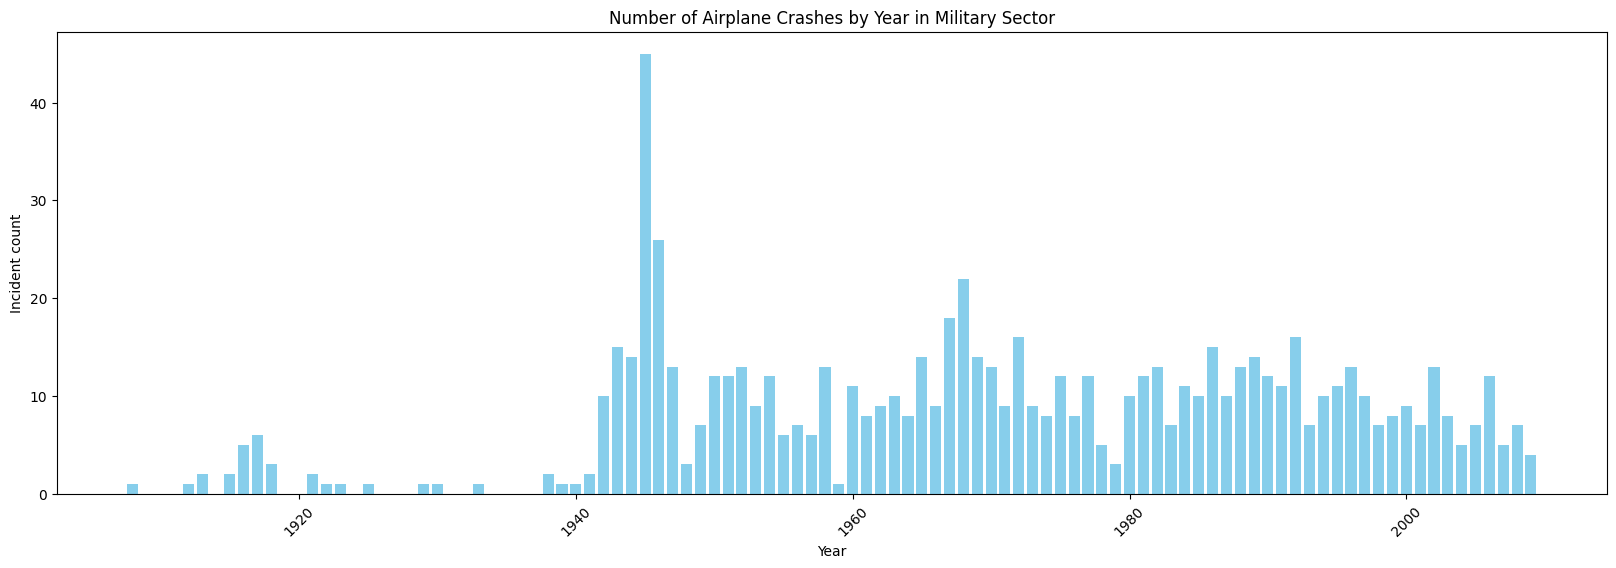

In [54]:
military_year_counts = military_df.groupby("year").size().reset_index(name="incident_count")
plt.figure(figsize=(20, 6))
plt.bar(military_year_counts["year"], military_year_counts["incident_count"], color="skyblue")
plt.xlabel("Year")
plt.ylabel("Incident count")
plt.title("Number of Airplane Crashes by Year in Military Sector")
plt.xticks(rotation=45)
plt.show()

On the graph, we observe two distinct peaks—around 1945 and 1975. These years correspond to some of the largest military conflicts of the 20th century: World War II and the Vietnam War. This may explain the increase in aviation accidents in the military sector.

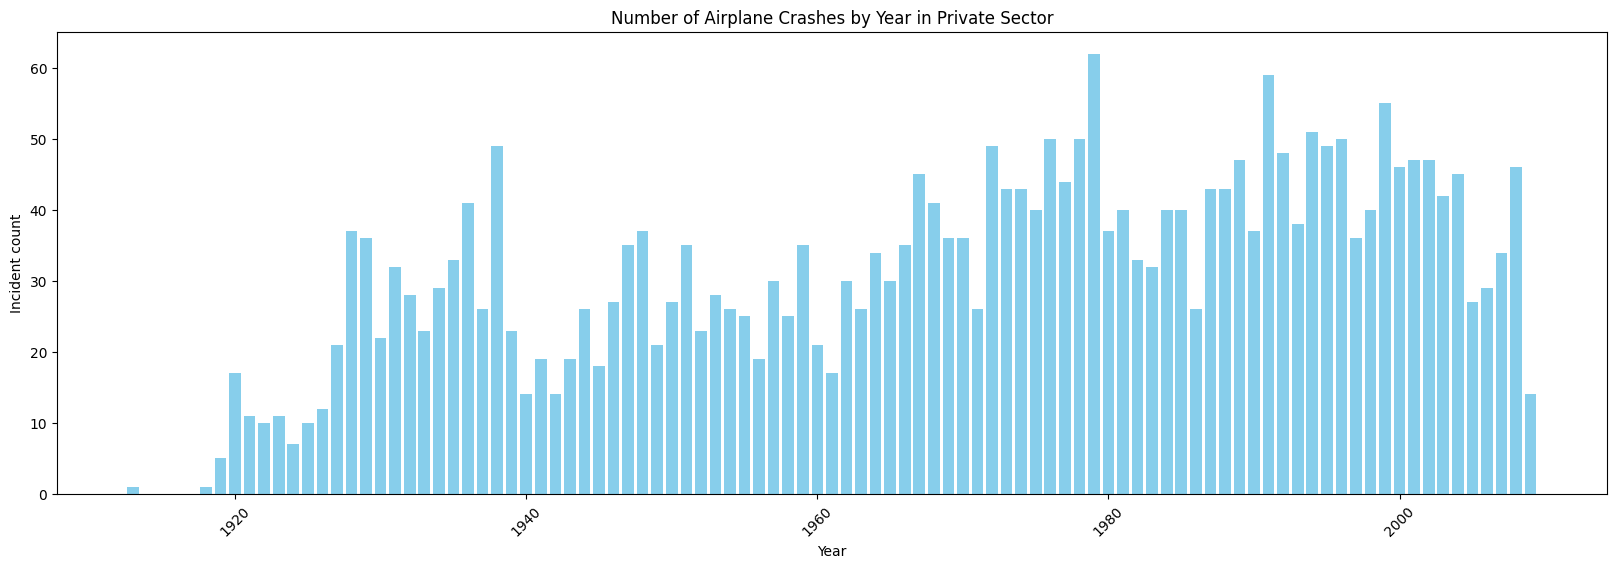

In [55]:
private_year_counts = private_df.groupby("year").size().reset_index(name="incident_count")
plt.figure(figsize=(20, 6))
plt.bar(private_year_counts["year"], private_year_counts["incident_count"], color="skyblue")
plt.xlabel("Year")
plt.ylabel("Incident count")
plt.title("Number of Airplane Crashes by Year in Private Sector")
plt.xticks(rotation=45)
plt.show()

Increase in incidents over time – Until the mid-20th century, the number of airplane crashes was rising. This could be due to the growing number of flights, the development of aviation, and imperfect technology.

Peaks in certain periods – There are noticeable spikes in accidents during the 1940s and 1970s. This may be related to military conflicts (such as World War II and the Vietnam War) or the rapid expansion of civil aviation.

Decrease in crashes in recent years – Since the 2000s, there is a visible trend of declining incidents, likely due to advancements in technology, improved safety standards, and stricter regulations in aviation.

Instability in different periods – After some peak years, there are periods of decline in accident rates, which could be influenced by economic crises, changes in the aviation industry, or regulatory measures.

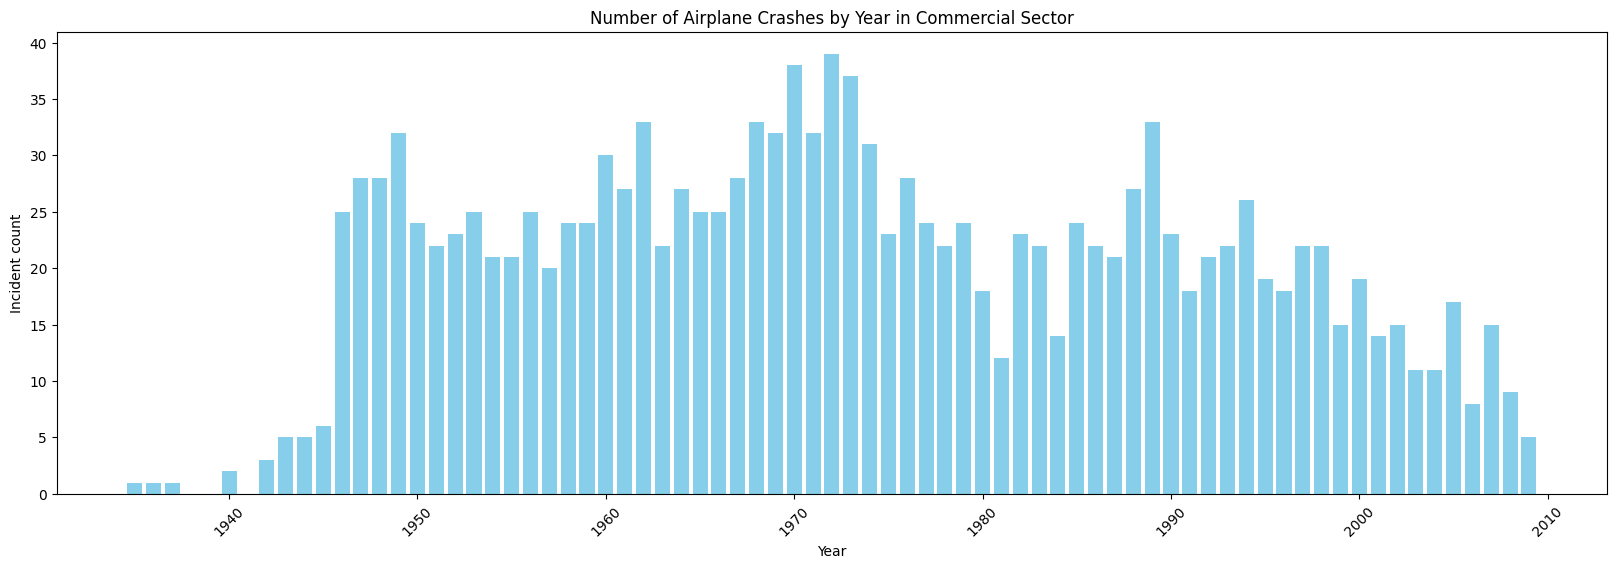

In [56]:
commercial_year_counts = commercial_df.groupby("year").size().reset_index(name="incident_count")
plt.figure(figsize=(20, 6))
plt.bar(commercial_year_counts["year"], commercial_year_counts["incident_count"], color="skyblue")
plt.xlabel("Year")
plt.ylabel("Incident count")
plt.title("Number of Airplane Crashes by Year in Commercial Sector")
plt.xticks(rotation=45)
plt.show()

*   There is a noticeable increase in incidents from the 1940s, peaking around the 1970s. The highest number of crashes appears to occur in the late 1960s to early 1980s. It likely correlates with the growth of commercial aviation.
*   A downward trend starts after the 1980s, with the number of crashes decreasing steadily until 2010. The decline after the 1980s may be attributed to improvements in aviation safety regulations, technology, and stricter operational standards.
*   After 2000, the number of airplane crashes dropped significantly. One of the key reasons was the tightening of security measures following the **2001 tragedy (the September 11 attacks)**, which led to major changes in the aviation industry. New safety standards were introduced, airport security was reinforced, and stricter cockpit access and piloting procedures were implemented. These factors, along with technological advancements, contributed to a significant reduction in commercial aviation accidents.

Let's focus on Geographical and Regional Factors.

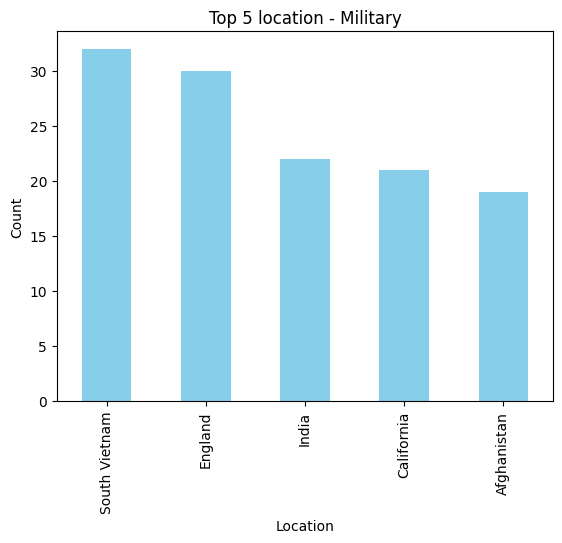

In [57]:
top_location_military = military_df['generalized_crash_location'].value_counts().head(5)
top_location_military.plot(kind='bar', color='skyblue')
plt.title('Top 5 location - Military')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

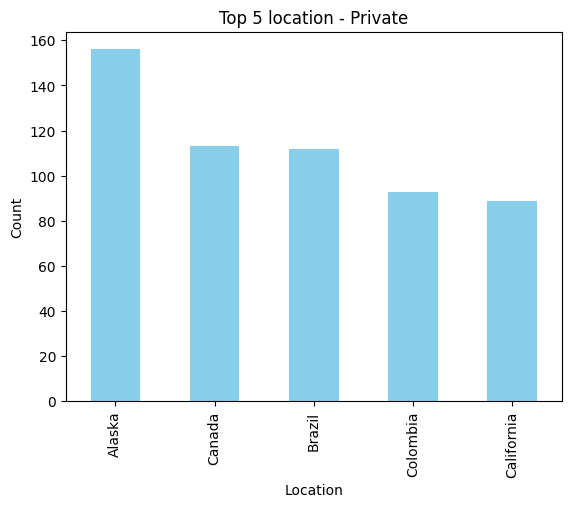

In [58]:
top_location_private = private_df['generalized_crash_location'].value_counts().head(5)
top_location_private.plot(kind='bar', color='skyblue')
plt.title('Top 5 location - Private')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

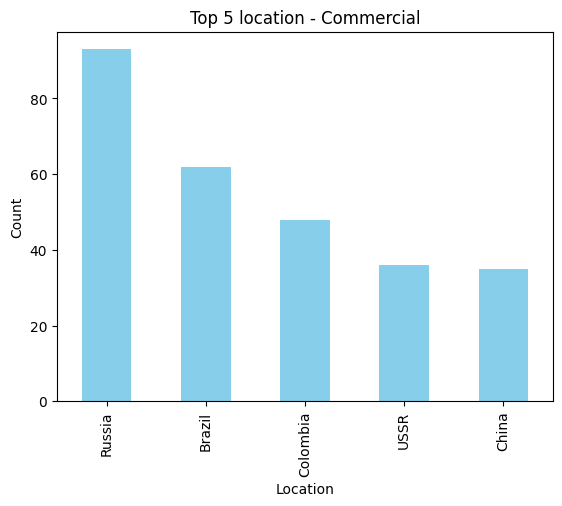

In [59]:
top_location_commercial = commercial_df['generalized_crash_location'].value_counts().head(5)
top_location_commercial.plot(kind='bar', color='skyblue')
plt.title('Top 5 location - Commercial')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

In [60]:
filtered_df = military_df[military_df['generalized_crash_location'] == 'South Vietnam']
top_causes_military_sv = filtered_df['summary'].value_counts().head(10)
top_causes_military_sv

,count
summary,
Hit a mountain shortly after taking off exploding in flames.,1
"While en route in poor weather, the plane struck trees on a mountain slope and then went into a flat spin, crashed and burned.",1
Ammunition exploded while the aircraft was on the ground.,1
Shot down by enemy fire over the Mekong Delta region.,1
The aircraft was hit by small arms fire shortly after taking off from SoTrang Air Base.,1
"Shot down by enemy fire, 60 miles north of Siagon.",1
"Shot down by enemy fire, 60 miles north of Saigon, shortly after taking off.",1
Metal fatigue of the spar in a blade led to separation of the blade and loss of control of the aircraft.,1
Crashed into a mountain after attempting to fly through a lowland area due to deteriorating weather conditions.,1


In [61]:
filtered_df = private_df[private_df['generalized_crash_location'] == 'Alaska']
top_causes_private_al = filtered_df['summary'].value_counts().head(10)
top_causes_private_al

,count
summary,
"Dense fog caused the pilot to make a forced landing about 15 miles south of Point Barrow. After some mechanical repairs, the plane took off, rose to about 50 feet and then crashed into shallow water. Loss of control of the aircraft at a low altitude after sudden engine failure due to the extreme nose-heaviness of the aircraft. Adventurer, Wiley Post, 37, and humorist, Will Rogers, 56, killed. Most experts believe that a combination of miscalculations in the design and operation of the heavily customized aircraft resulted in the uncontrollable spin that occurred right after takeoff.",1
A total loss of power was experienced on takeoff due to the fuel selectors being in the off position. The pilot attempted to restart the engine during which time the aircraft entered a stall and collided with the terrain. Checklist not used. Fuel tank selector in wrong position.,1
Lost control of the aircraft and crashed in a snow storm. Continued VFR flight in IFR conditions.,1
"The aircraft collided with the waters of the narrow strait, northwest of Monashka Bay. Witnesses reported the weather was IFR in the area at the time. The aircraft was not equipped for instrument flight nor was the pilot current with FARS to conduct IFR operations. Continued VFR flight into IMC.",1
Disappeared en route. Aircraft and occupants never found. Reasons undetermined.,1
Crashed into trees while attempting a go-around in poor weather. Improper minimum descent atlitiude and missed approach. Improper inflight decision. Improper missed approach. Minimum descent altitude not maintained.,1
"According to the pilot-in-command, he was attempting to fly through a mountain saddle. As he turned towards the mountain and began his climb the weather deteriorated rapidly with ceilings zero, visibility zero and severe turbulence. The airplane struck the side of a 1,707 foot high mountain at the 1,590 foot level on a magnetiheading of 015 degrees. The pilot-in-command stated that just prior to impact he could not see anything. Continued VFR flight into IMC. Poor judgement. Improper planning.",1
"During a night arrival, the flight was on an instrument approach to the Gulkana Airport when radio contact with the aircraft was lost. Search was initiated & the wreckage was found 7.4 mi north of the terminal VORr on the 330 deg radial. Improper IFR procedure. Minimum descent altitude not maintained.",1
"The air ambulance crashed into a mountain at 3,500 ft. while attempting to land. Crew became lost and disoriented and made a premature descent.",1


In [62]:
filtered_df = commercial_df[commercial_df['generalized_crash_location'] == 'Russia']
top_causes_commercial_rus = filtered_df['summary'].value_counts().head(10)
top_causes_commercial_rus

,count
summary,
Unknown,3
Crashed during takeoff (or shortly after),2
"Midair collision with an I-5 fighter at 2,300 ft. The fighter was performing aerobatics trying to loop around the Tupolev. The plane crashed into a residental neighborhood and was on its maiden flight. The plane was nicknamed 'Maxim Gorky.' Pilot error. Forty-nine killed on the Tupolev, one on the I-5",1
The aircraft crashed while attempting an emergency landing after the No. 3 engine caught fire. Failure of a compressor.,1
A fire in the rear cargo hold and fire warning in both engines forced the plane to crash land in a snow laden field. The plane broke up after striking irrigation equipment. Short circuit in the electrical wiring.,1
Crashed right of the runway during an approach in haze and snow.,1
Descended below minima and struck a mountain. Did not heed GPWS warnings. Incorrectly set altimeter.,1
"The aircraft made a hard landing beside the runway, broke up and caught fire. Crew error. Visual contact with the runway was lost as the aircraft descended through the decision height.",1
"The plane stalled and crashed after a loss of engine power on takeoff. The engine throttles were reduced at a critical stage of the takeoff for undetermined reasons, probably by the crew.",1


*   Military aviation accidents are concentrated in regions with active combat operations or challenging terrain and weather conditions. In South Vietnam, most crashes were caused by enemy fire, collisions with mountains in poor weather, and technical failures.
*   Private aviation accidents often occur in remote and geographically challenging areas such as Alaska and Canada. The main causes are pilot errors, including navigation mistakes, ignoring weather conditions, failure to follow checklists, and equipment malfunctions.
*   Commercial aviation accidents are more frequent in countries with developing infrastructure (Russia, Brazil, Colombia), which may be linked to an aging fleet, insufficient maintenance control, and crew errors. The primary causes include takeoff and landing accidents, pilot mistakes, and technical failures.

Let's focus then on Aircraft and The Airport and The Runway Condition

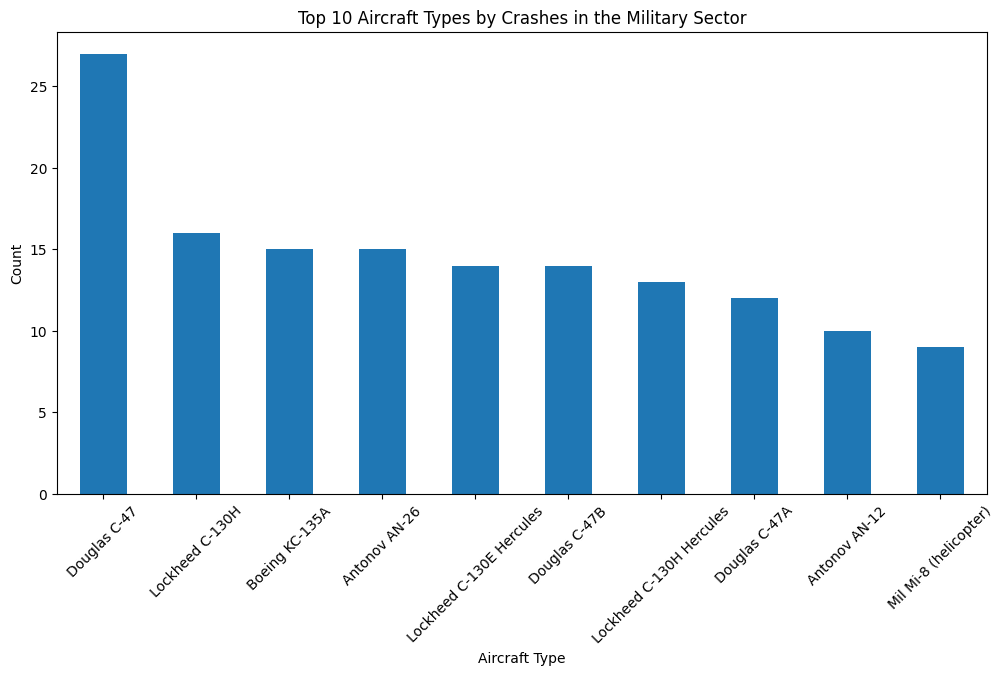

In [63]:
aircraft_accidents_military = military_df['aircraft_type'].value_counts()
plt.figure(figsize=(12, 6))
aircraft_accidents_military[:10].plot(kind='bar')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.title('Top 10 Aircraft Types by Crashes in the Military Sector')
plt.xticks(rotation=45)
plt.show()

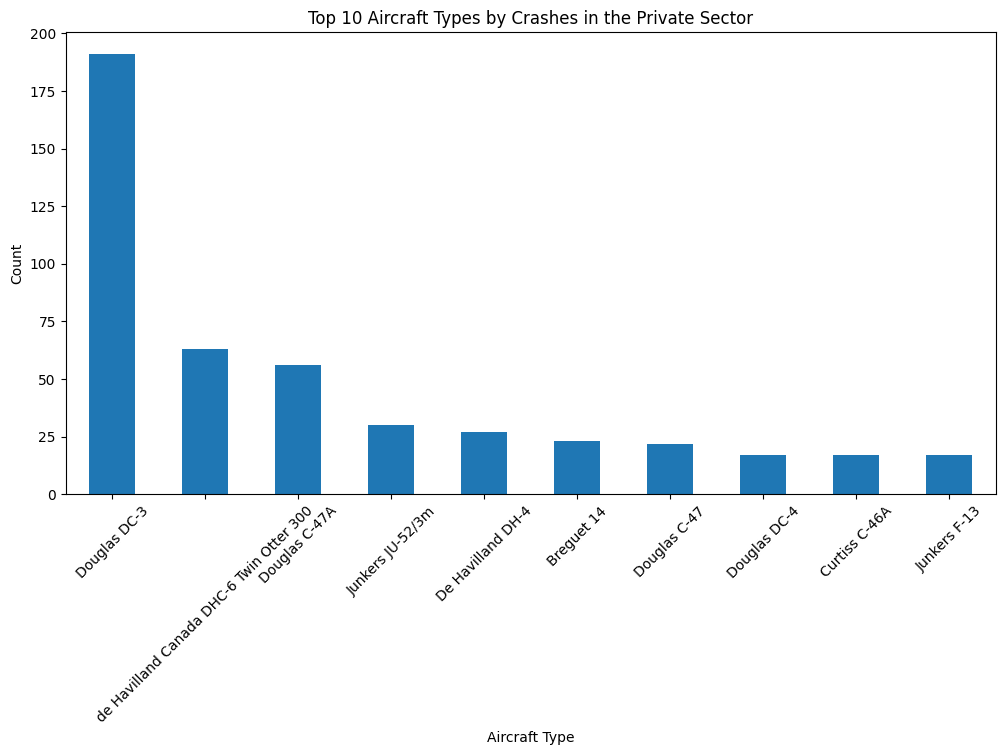

In [64]:
aircraft_accidents_private = private_df['aircraft_type'].value_counts()
plt.figure(figsize=(12, 6))
aircraft_accidents_private[:10].plot(kind='bar')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.title('Top 10 Aircraft Types by Crashes in the Private Sector')
plt.xticks(rotation=45)
plt.show()

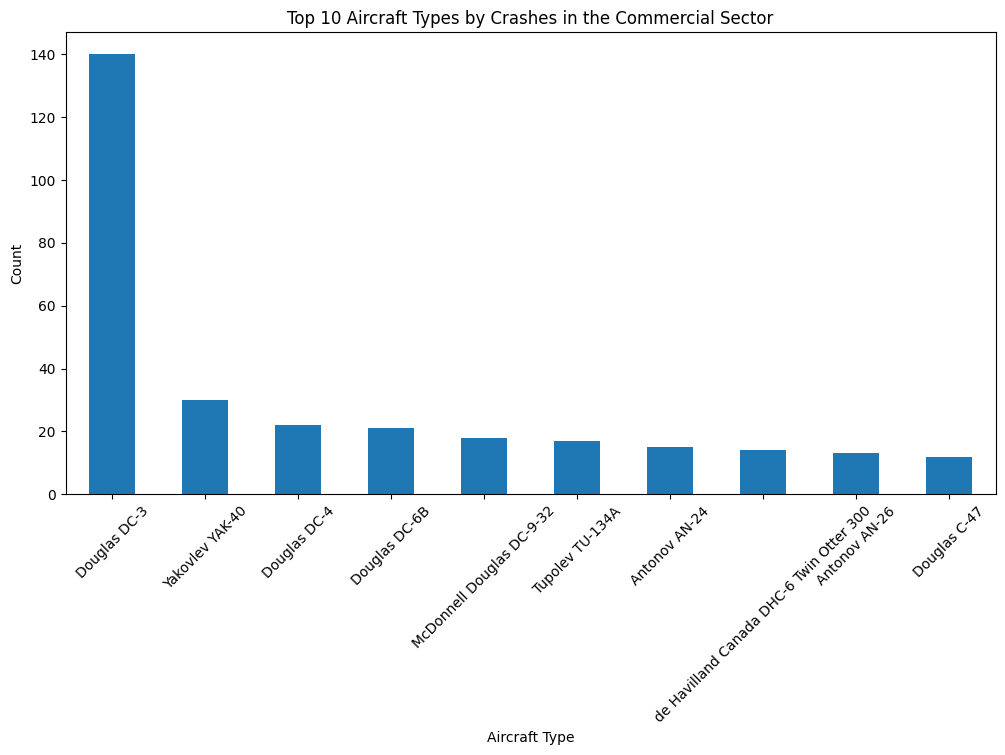

In [65]:
aircraft_accidents_commercial = commercial_df['aircraft_type'].value_counts()
plt.figure(figsize=(12, 6))
aircraft_accidents_commercial[:10].plot(kind='bar')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.title('Top 10 Aircraft Types by Crashes in the Commercial Sector')
plt.xticks(rotation=45)
plt.show()

In [66]:
filtered_df = df[df['aircraft_type'] == 'Douglas DC-3']
top_causes_douglas = filtered_df['summary'].value_counts().head(10)
top_causes_douglas

,count
summary,
Unknown,14
Crashed during takeoff (or shortly after),10
Crashed en route,7
"Crashed into an obstacle (mountain, sea, etc.)",6
Crashed while attempting to land,3
Cargo plane crash,2
Crashed into Mt. Baco while en route. Navigational error under adverse weather conditions.,1
Crashed while en route. Navigation error. Failure of the crew to follow the prescribed route. Flying VFR in IFR conditions.,1
Disappeared while en route. The wreckage was never found. It is believed the aircraft crashed into the sea off the island of Madura.,1


The Douglas DC-3 appears frequently in crash statistics across military, private, and commercial aviation, indicating its widespread use and long operational history. The main causes of DC-3 accidents include takeoff failures, en route crashes, collisions with obstacles (mountains, sea), and landing difficulties. Additionally, given the aircraft's age, it's crucial to carefully monitor its technical condition, conduct regular maintenance, and assess the structural integrity of aging components to reduce accident risks.

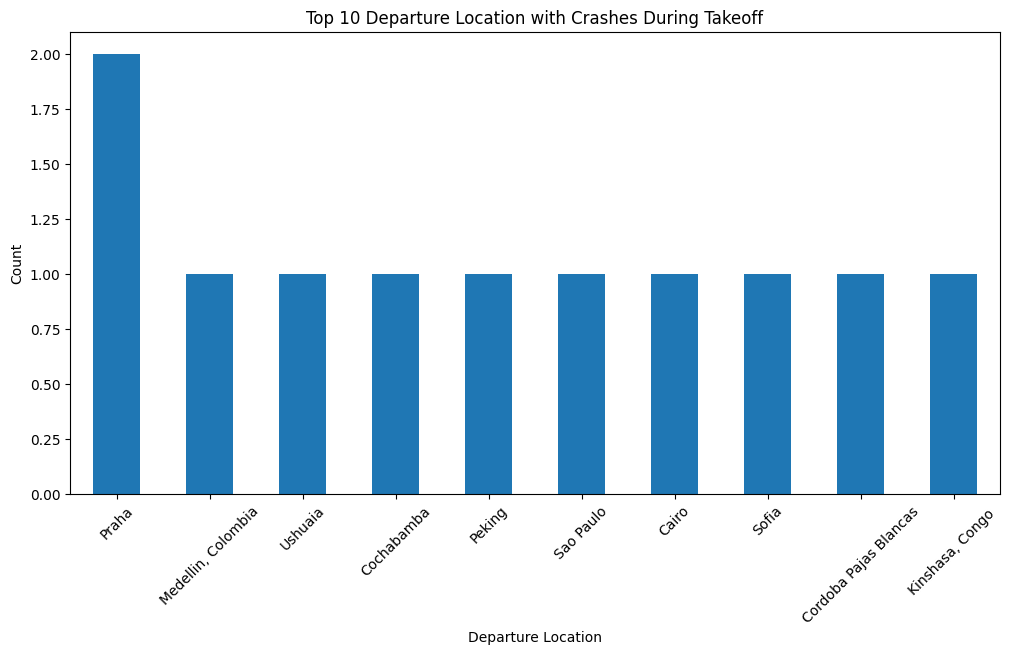

In [75]:
filtered_df = df[(df['summary'] == 'Crashed during takeoff (or shortly after)') & (df['departure_location'] != 'Unknown')]
takeoff_accidents_location = filtered_df['departure_location'].value_counts()
plt.figure(figsize=(12, 6))
takeoff_accidents_location[:10].plot(kind='bar')
plt.xlabel('Departure Location')
plt.ylabel('Count')
plt.title('Top 10 Departure Location with Crashes During Takeoff')
plt.xticks(rotation=45)
plt.show()

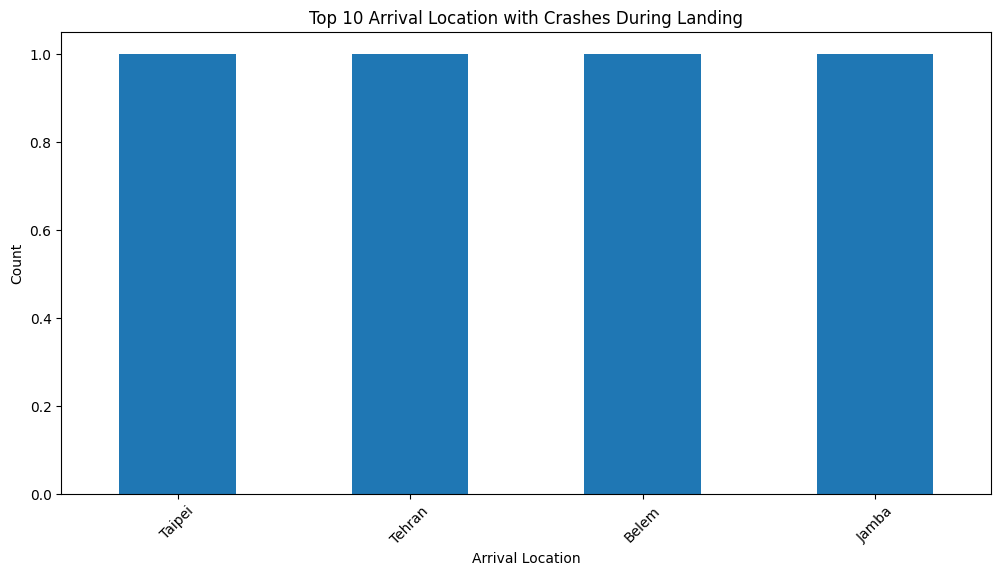

In [76]:
filtered_df = df[(df['summary'] == 'Crashed while attempting to land') & (df['arrival_location'] != 'Unknown')]
takeoff_accidents_location = filtered_df['arrival_location'].value_counts()
plt.figure(figsize=(12, 6))
takeoff_accidents_location[:4].plot(kind='bar')
plt.xlabel('Arrival Location')
plt.ylabel('Count')
plt.title('Top 10 Arrival Location with Crashes During Landing')
plt.xticks(rotation=45)
plt.show()

Based on the number of incidents, no conclusions can be drawn about the correlation between the condition of runways in different countries and the number of accidents.

Let's also focus on human factor influence


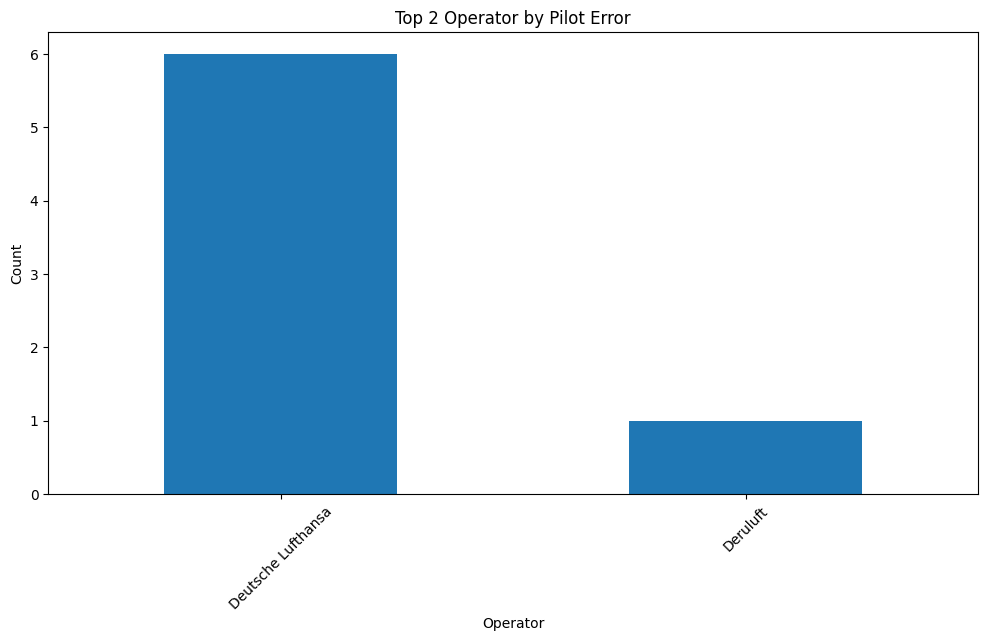

In [78]:
filtered_df = df[(df['summary'] == 'Pilot error')]
pilot_accidents_operator = filtered_df['operator'].value_counts()
plt.figure(figsize=(12, 6))
pilot_accidents_operator[:4].plot(kind='bar')
plt.xlabel('Operator')
plt.ylabel('Count')
plt.title('Top 2 Operator by Pilot Error')
plt.xticks(rotation=45)
plt.show()

In general, it can be said that there is not enough data from a long time ago to draw any conclusions. However, the high number of accidents due to pilot error at Deutsche Lufthansa may be due to operational strain, stress, training problems or violations of standard procedures, despite the high level of training.